In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision=5, suppress = True)
pd.options.display.float_format = '{:.5f}'.format

## Частина перша: статистика Дарбіна-Уотсона

In [2]:
def DurbinWatson(eps):
    return ((eps[1:] - eps[:-1])**2).sum()/(eps**2).sum()

In [3]:
dw_test = np.loadtxt('./lab3_data/example_for_DW.txt')

In [4]:
DurbinWatson(dw_test)

1.2288100804239723

## Частина друга: побудова адекватного рівняння для опису процесу

In [5]:
rts1 = pd.read_csv('./lab3_data/rts1.txt', squeeze=True, header=None, names=['rts1'])
rts1996 = pd.read_csv('./lab3_data/1996rts1.txt', squeeze=True, header=None, names=['1996rts1'])

Описові характеристики та гістрограма

In [6]:
from scipy.stats import jarque_bera

def DescrStats(series):
    return pd.Series({
        'Mean': series.mean(),
        'Median': series.median(),
        'Maximum': series.max(),
        'Minimum': series.min(),
        'Std. Dev.': series.std(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurt(),
        'Jarque-Bera': jarque_bera(series).statistic,
        'Probability': jarque_bera(series).pvalue
    })

Mean          2043.53730
Median        2068.17000
Maximum       2487.92000
Minimum       1058.84000
Std. Dev.      289.92145
Skewness        -1.08290
Kurtosis         1.44227
Jarque-Bera     48.09477
Probability      0.00000
dtype: float64


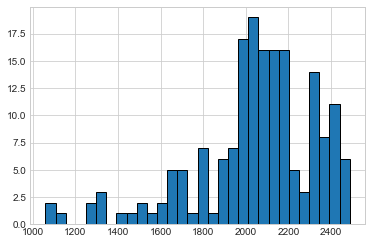

In [7]:
print(DescrStats(rts1))
plt.hist(rts1, bins=30, facecolor='tab:blue', edgecolor='black')
plt.show()

Mean          142.14739
Median        163.15000
Maximum       227.79000
Minimum        66.69000
Std. Dev.      46.97269
Skewness       -0.36054
Kurtosis       -1.47324
Jarque-Bera    27.68269
Probability     0.00000
dtype: float64


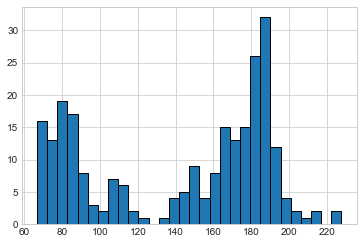

In [8]:
print(DescrStats(rts1996))
plt.hist(rts1996, bins=30, facecolor='tab:blue', edgecolor='black')
plt.show()

Реалізація АКФ, ЧАКФ та ковзних середніх (з ЛР №2)

In [9]:
def ACF(data, maxlag=None):
    N = maxlag if maxlag else data.size
    return np.array([((data - data.mean()) * (data.shift(s) - data.mean())).sum()
            / ((data.size - 1) * data.var())
            for s in range(1, data.size+1)][:N])

def PACF(data, maxlag=None):
    N = maxlag if maxlag else data.size
    r = ACF(data)
    phi = np.zeros((N, N))
    phi[0, 0] = r[0]   
    for k in range(1, N):
        sum_top = sum([phi[k-1, j]*r[k-1-j] for j in range (0, k)])
        sum_bottom = sum([phi[k-1, j]*r[j] for j in range (0, k)])
        phi[k, k] = (r[k] - sum_top) / (1 - sum_bottom)
        for j in range(0, k):
            phi[k, j] = phi[k-1, j] - phi[k, k]*phi[k-1, k-1-j]
            phi[j, k] = phi[k, j]      
    return np.diag(phi)

def SMA(data, N):
    sma = data.rolling(N).mean()
    sma.name += f' SMA (N={N})'
    return sma

def EMA(data, N, return_weights=False):
    a = 2 / (N + 1)
    w = [(1 - a)**n for n in range(N, 0, -1)]
    ema = data.rolling(N).apply(lambda window: (w * window).sum() / sum(w))
    ema.name += f' EMA (N={N})'
    return (ema, w) if return_weights else ema

Статистики для моделі

In [10]:
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

def r_squared(y_true, y_pred):
    return y_pred.var()/y_true.var()

def log_likelihood(y_true, y_pred):
    N = len(y_pred)
    return -N/2*(np.log(2*np.pi) + np.log(sum_squared_error(y_true, y_pred)/N))

def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] + 1
    N = y_true.size 
    return -2*log_likelihood(y_true, y_pred)/N + 2*n/N

def schwarz(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] + 1
    N = y_true.size 
    return -2*log_likelihood(y_true, y_pred)/N + n*np.log(N)/N

def ModelEstimation(y_true, y_pred, ARMA):
    N = len(y_pred)
    n = ARMA[0] + ARMA[1] + 1
    return pd.Series({
        'R-squared': r_squared(y_true, y_pred),
        'Adjusted R-squared': 1 - (1-r_squared(y_true, y_pred))*((N-1)/(N-n-1)),
        'S.E. of regression': np.sqrt(sum_squared_error(y_true, y_pred)/N),
        'Sum squared resid': sum_squared_error(y_true, y_pred),
        'Log likelihood': log_likelihood(y_true, y_pred),
        'Durbin-Watson stat': DurbinWatson(y_pred - y_true),
        'Mean dependent var': y_pred.mean(),
        'S.D. dependent var': y_pred.std(),
        'Akaike info criterion': akaike(y_true, y_pred, ARMA),
        'Schwarz criterion': schwarz(y_true, y_pred, ARMA)
    })

Побудова моделі

In [303]:
def ARMA(y, ma_window, ma_type, method='resid', pacf_tolerance=None):
    """
    Estimate (p, q) for ARMA(p, q) and fit to y
    
    y               - time series
    ma_window       - moving average window
    ma_type         - sma or ema for simple or exponential moving average
    method          - way of estimating q
    pacf_tolerance  - threshold for choosing q by PACF, 
                      if None, using 1.96/sqrt(len(y))
    Methods:
        resid       - q estimated using PACF of AR(p) residuals
        direct_1    - q estimated using PACF of y moving average, coefs are precomputed
        direct_2    - q estimated using PACF of y moving average, coefs are fitted
    """
    N = ma_window
    if pacf_tolerance is None:
        pacf_tolerance = 1.96 / np.sqrt(len(y))
    try:
        p = np.where(abs(PACF(y, maxlag=12)) >= pacf_tolerance)[0].max()+1
    except ValueError:
        p = 0

    if method == 'resid':
        Y = np.ones((len(y)-p, p+1))
        for k in range(1, p+1):
            Y[:, k] = y[p-k:-k]
        a_coef = np.linalg.pinv(Y.T @ Y) @ Y.T @ y[p:]
        residuals = y[p:] - Y @ a_coef
        try:
            q = np.where(abs(PACF(residuals.dropna(), maxlag=12)) >= pacf_tolerance)[0].max()+1
        except ValueError:
            q = 0
        if ma_type == 'sma':
            ma = SMA(residuals, N)
        elif ma_type == 'ema':
            ma = EMA(residuals, N)
        else: raise ValueError('unknown Moving Average type') 
        ma = ma.dropna()
        actual = y[ma.index[0]:]
        X = np.ones((len(actual)-max(p, q), p+q+1))
        for k in range(1, p+1):
            X[:, k] = actual[max(p, q)-k:-k]
        for k in range(1, q+1):
            X[:, p+k] = ma[max(p, q)-k:-k]
        a_coef = np.linalg.pinv(X.T @ X) @ X.T @ (actual - ma)[max(p, q):]
        fitted = X @ a_coef + ma[max(p, q):]
        fitted.name += ' fitted'

    elif method == 'direct_1' or method == 'direct_2':
        if ma_type == 'sma':
            ma = SMA(y, N)
        elif ma_type == 'ema':
            ma = EMA(y, N)
        else: raise ValueError('unknown Moving Average type') 
        try:
            #q = np.where(abs(PACF(ma.dropna(), maxlag=12)) >= pacf_tolerance)[0].max()+1
            q = 3
        except ValueError:
            q = 0
        if method == 'direct_1':
            alpha = 2/(q+1)
            b_coef = np.array([(1-alpha)**j for j in range(1, q+1)])
            b_coef = b_coef/b_coef.sum() if q>1 else np.ones(1)
            ma = ma.dropna()
            actual = y[ma.index[0]:]
            ma_matrix = np.ones((len(ma)-q, q))
            for k in range(q):
                ma_matrix[:, q-k-1] = ma.shift(q-k)[q:]
            y1 = actual[q:] - ma[q:] - ma_matrix @ b_coef
            print(y1)
            Y = np.ones((len(y1), p+1))
            start_ind = y1.index[0]
            for k in range(1, p+1):
                Y[:, k] = y[start_ind-k:-k]
            a_coef = np.linalg.pinv(Y.T @ Y) @ Y.T @ y1
            actual = y1 + ma_matrix @ b_coef + ma.dropna()
            fitted = Y @ a_coef + ma_matrix @ b_coef + ma.dropna()[max(p, q):]
            a_coef = np.concatenate((a_coef, b_coef))

    return {'actual': actual[max(p, q):],
            'fitted': fitted,
            'coefficients': a_coef,
            'residuals': actual[max(p, q):] - fitted,
            'moving_average': ma,
            'model_order': (p, q)}


In [288]:
estim['coefficients']

array([-614.32287,    0.78914,   -1.50854,    0.57143,    0.28571,
          0.14286])

12    -2236.38843
13    -2223.74171
14    -2127.38571
15    -2098.49171
16    -2117.99714
          ...    
173   -1659.38971
174   -1717.01143
175   -1690.59429
176   -1592.85871
177   -1289.03400
Length: 166, dtype: float64
R-squared                     1.09577
Adjusted R-squared            1.09938
S.E. of regression          106.88513
Sum squared resid       1896455.59981
Log likelihood             -928.05508
Durbin-Watson stat            0.44552
Mean dependent var         2034.67271
S.D. dependent var          308.20313
Akaike info criterion        11.25368
Schwarz criterion            11.36616
dtype: float64


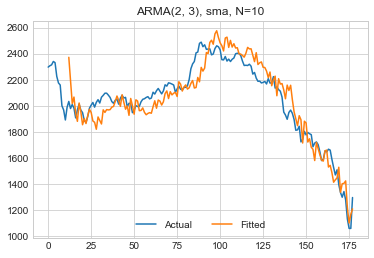

In [305]:
model_params = {
    'y': rts1,
    'ma_window': 10,
    'ma_type': 'sma',
    'method': 'direct_1'
}
estim = ARMA(**model_params)
plt.plot(model_params['y'], label='Actual')
plt.plot(estim['fitted'], label='Fitted')
plt.title(f'ARMA{estim["model_order"]}, {model_params["ma_type"]}, N={model_params["ma_window"]}')
plt.legend(loc='lower center', ncol=2)
print(ModelEstimation(estim['actual'].values, estim['fitted'].values, estim['model_order']))

## Частина третя: побудова рівняння множинної регресії.

In [13]:
def pearson_correlation(x, y):
    if x.shape != y.shape: raise ValueError("Shapes must be equal")
    return np.sum((x-x.mean()) * (y-y.mean())) / (x.std() * y.std() * (len(x)-1))

In [14]:
import re
import os

df = pd.read_csv('./lab3_data/rts1.txt', header=None, names=['rts1'])

rts = [file for file in os.listdir('./lab3_data') if re.match(r'^RTS', file)]

for index in rts:
    df[index.split('.')[0]] = np.loadtxt('./lab3_data/'+index)
    
df.head()

,rts1,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl
0,2296.56000,374.12000,465.29000,786.31000,408.62000,363.97000,288.90000,322.85000
1,2306.87000,376.17000,463.22000,788.79000,409.33000,368.81000,289.56000,322.59000
2,2313.90000,380.34000,463.92000,792.27000,413.30000,369.50000,289.20000,324.09000
3,2339.79000,382.76000,465.09000,796.21000,414.34000,376.52000,293.30000,328.12000
4,2330.87000,386.37000,468.23000,793.43000,417.96000,376.05000,291.39000,328.72000


In [15]:
corr = pd.DataFrame(
    [df.apply(lambda x: pearson_correlation(x, df[col1])) for col1 in df.columns],
    index = df.columns
)

corr

,rts1,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl
rts1,1.00000,0.84843,0.63838,0.87944,0.85919,0.92894,0.96139,0.82255
RTScr,0.84843,1.00000,0.92908,0.96056,0.89771,0.85171,0.68234,0.95693
RTSeu,0.63838,0.92908,1.00000,0.87830,0.79404,0.69767,0.41247,0.88717
RTSfn,0.87944,0.96056,0.87830,1.00000,0.82822,0.80888,0.73931,0.92530
RTSin,0.85919,0.89771,0.79404,0.82822,1.00000,0.94445,0.72615,0.88604
RTSmm,0.92894,0.85171,0.69767,0.80888,0.94445,1.00000,0.84123,0.79823
RTSog,0.96139,0.68234,0.41247,0.73931,0.72615,0.84123,1.00000,0.66756
RTStl,0.82255,0.95693,0.88717,0.92530,0.88604,0.79823,0.66756,1.00000


Результати аналогічні вбудованій функції, тому надалі для зручності використовуватимемо саме її

In [16]:
df.corr()

,rts1,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl
rts1,1.00000,0.84843,0.63838,0.87944,0.85919,0.92894,0.96139,0.82255
RTScr,0.84843,1.00000,0.92908,0.96056,0.89771,0.85171,0.68234,0.95693
RTSeu,0.63838,0.92908,1.00000,0.87830,0.79404,0.69767,0.41247,0.88717
RTSfn,0.87944,0.96056,0.87830,1.00000,0.82822,0.80888,0.73931,0.92530
RTSin,0.85919,0.89771,0.79404,0.82822,1.00000,0.94445,0.72615,0.88604
RTSmm,0.92894,0.85171,0.69767,0.80888,0.94445,1.00000,0.84123,0.79823
RTSog,0.96139,0.68234,0.41247,0.73931,0.72615,0.84123,1.00000,0.66756
RTStl,0.82255,0.95693,0.88717,0.92530,0.88604,0.79823,0.66756,1.00000


In [17]:
df[['rts1', 'RTStl', 'RTScr', 'RTSfn']].corr()

,rts1,RTStl,RTScr,RTSfn
rts1,1.00000,0.82255,0.84843,0.87944
RTStl,0.82255,1.00000,0.95693,0.92530
RTScr,0.84843,0.95693,1.00000,0.96056
RTSfn,0.87944,0.92530,0.96056,1.00000


Спостерігаємо сильну корреляцію між змінними RTStl, RTScr, RTSfn, з трьох залишимо RTSfn, оскільки вона корелює з цільовою змінною найсильніше

Змінна RTSeu має порівняно невеликий коефіцієнт корреляції з rts1, проте й не має суттєвої корреляції з іншими змінними, тому залишимо її в списку предикторів.

Останньою неоднозначною змінною залишається RTSin, що сильно корелює з RTSmm. Спробуємо її також прибрати

In [18]:
excluded = {'rts1', 'RTStl', 'RTScr', 'RTSin'}
predictors = list(set(df.columns) - excluded)
df[['rts1'] + predictors].corr()

,rts1,RTSeu,RTSog,RTSmm,RTSfn
rts1,1.00000,0.63838,0.96139,0.92894,0.87944
RTSeu,0.63838,1.00000,0.41247,0.69767,0.87830
RTSog,0.96139,0.41247,1.00000,0.84123,0.73931
RTSmm,0.92894,0.69767,0.84123,1.00000,0.80888
RTSfn,0.87944,0.87830,0.73931,0.80888,1.00000


In [19]:
import statsmodels.api as sm

y = df['rts1']
X = df[predictors]

X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                   rts1   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.294e+04
Date:                Fri, 12 Mar 2021   Prob (F-statistic):          4.71e-258
Time:                        19:31:47   Log-Likelihood:                -647.02
No. Observations:                 178   AIC:                             1304.
Df Residuals:                     173   BIC:                             1320.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.0745      5.351     -8.237      0.0

## Частина четверта: творча, ARMAX

In [20]:
import statsmodels.tsa.tsatools as tsa

def PCF(y, x, maxlag=None):
    N = maxlag+1 if maxlag else 1
    r = [pearson_correlation(x.shift(k)[k:], y[k:]) for k in range(N)]
    phi = np.zeros((N, N))
    phi[0, 0] = r[0]   
    for k in range(1, N):
        sum_top = sum([phi[k-1, j]*r[k-1-j] for j in range (0, k)])
        sum_bottom = sum([phi[k-1, j]*r[j] for j in range (0, k)])
        phi[k, k] = (r[k] - sum_top) / (1 - sum_bottom)
        for j in range(0, k):
            phi[k, j] = phi[k-1, j] - phi[k, k]*phi[k-1, k-1-j]
            phi[j, k] = phi[k, j]      
    return np.diag(phi)

X.iloc[:,1:].apply(lambda x: PCF(y, x, 12))

,RTSeu,RTSog,RTSmm,RTSfn
0,0.63838,0.96139,0.92894,0.87944
1,0.35504,0.28471,0.46852,0.38171
2,0.22004,0.01382,0.29287,0.18795
3,0.13959,-0.02432,0.20711,0.10098
4,0.08699,-0.02781,0.17217,0.03784
5,0.05475,0.00628,0.16942,-0.00029
6,0.03716,-0.07117,0.11698,-0.00625
7,0.02756,-0.06525,0.05752,-0.00210
8,0.02488,-0.03769,0.01753,-0.00577
9,0.03868,0.00266,-0.02763,0.01989
